# Language Model (Bengio, 2003)
MLP with Word Embeddings

Author: **Rafael Ito**  
e-mail: ito.rafael@gmail.com

## 0. Dataset and Description

**Name:**  WikiText-2  
**Description:** this notebook uses the WikiText-2 dataset which is a language modeling dataset with over 2 millions tokens. The aim here is to build a language model that predicts the next word based on a sequence of NGRAM previous words, such as that found in the paper "A Neural Probabilistic Language Model" from Yoshua Bengio, 2003.

## 1. Libraries and packages

### 1.1 Install packages

In [0]:
!pip install -q \
    torch       \
    numpy       \
    sklearn     \
    matplotlib  

### 1.2 Import libraries

In [0]:
#-------------------------------------------------
# general
#-------------------
import numpy as np
import collections
import itertools
from scipy.sparse import csr_matrix
#-------------------------------------------------
# PyTorch
#-------------------
import torch
from torch.utils.data import TensorDataset
import torch.nn.functional as F
#-------------------------------------------------
# scikit-learn
#-------------------
from sklearn.preprocessing import OneHotEncoder
#-------------------------------------------------
# data visualization
#-------------------
import matplotlib.pyplot as plt
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
torch.manual_seed(42);

### 1.3 Check device

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('Device:', device)

Device: cuda


### 1.4 Constants definition

In [0]:
# choose which embedding will be used: PyTorch class or own implementation
#PYTORCH_EMBEDDING = False
PYTORCH_EMBEDDING = True
#-------------------
# activate debug mode, limiting the vocab size and amount of tokens
#DEBUG = True
DEBUG = False
#-------------------
# define the size of embeddings
EMBEDDING_DIM = 32
#-------------------
# define n-gram to be used: 5 context words
NGRAM = 5
#-------------------
# define number of neurons in hidden layer
HIDDEN_SIZE = 100

## 2. Dataset

### 2.1 Download

In [5]:
# download dataset
!wget -nc https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -o wikitext-2-v1.zip

--2020-03-25 23:19:52--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.18.163
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.18.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4475746 (4.3M) [application/zip]
Saving to: ‘wikitext-2-v1.zip’

wikitext-2-v1.zip   100%[===================>]   4.27M  9.91MB/s    in 0.4s    

2020-03-25 23:19:58 (9.91 MB/s) - ‘wikitext-2-v1.zip’ saved [4475746/4475746]

Archive:  wikitext-2-v1.zip
   creating: wikitext-2/
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


### 2.2 Dataset preparation

Function that loads the text dataset and return the tokens.

In [0]:
def load_tokens(path):
    text = open(path).read().lower()
    # Split sem argumentos remove quebras de linha e espaços duplicados.
    return text.split()

Function that take as input the tokens and return the vocab organized based on the frequency of the words.

In [0]:
def build_vocab(tokens, vocab_size):
    word_frequency = collections.Counter(tokens)

    vocab = {token: index for index, (token, _) in enumerate(
        word_frequency.most_common(vocab_size))}

    # Adicionamos o token "<unk>" para lidar com palavras não presentes no
    # vocabulário . O dataset text8 já contem este token, mas pode ser que ele
    # não tenha sido adicionado quando filtramos com `vocab_size`.
    if '<unk>' not in vocab:
        vocab['<unk>'] = len(vocab)
    return vocab 

Loading training, validation and test tokens.

In [0]:
train_tokens = load_tokens('wikitext-2/wiki.train.tokens')
valid_tokens = load_tokens('wikitext-2/wiki.valid.tokens')
test_tokens = load_tokens('wikitext-2/wiki.test.tokens')

In [9]:
# size of the each dataset
len(train_tokens), len(valid_tokens), len(test_tokens)

(2051910, 213886, 241211)

### 2.3 Check if in DEBUG mode

If in DEBUG mode, limit the dataset taking the first 10,000 tokens.

In [0]:
if DEBUG:
    train_tokens = train_tokens[:10_000]
    valid_tokens = valid_tokens[:10_000]
    test_tokens  = test_tokens[:10_000]
#-------------------------------------------------
# even if not in debug mode, limit size of dataset due to the long time to train the network
else:
    #train_tokens = train_tokens[:100_000]
    train_tokens = train_tokens[:25_000]
    valid_tokens = valid_tokens[:100_000]
    test_tokens  = test_tokens[:100_000]

If in DEBUG mode, limit the vocab to the 1,000 most frequent words.

In [11]:
vocab_size = 1_000 if DEBUG else 10_000
vocab = build_vocab(train_tokens, vocab_size=vocab_size)
print(f'Vocab has {len(vocab)} tokens')
print(f'10 sample tokens: {list(itertools.islice(vocab.keys(), 10))}')

Vocab has 4124 tokens
10 sample tokens: ['the', ',', '.', '<unk>', 'of', 'and', 'in', 'to', 'a', '=']


### 2.4 Padding

Create '<pad>' padding word in vocab:

In [0]:
# replace the last vocab with the '<pad>' padding token:
if '<pad>' not in vocab:
    vocab['<pad>'] = len(vocab)
    vocab_size = len(vocab)

Add the padding token at the beginning of each dataset:

In [13]:
# create padding list to be concatenated with tokens dataset
padding_list = NGRAM * ['<pad>']
padding_list

['<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

In [0]:
# concatenate the padding list removing the last NGRAM tokens
train_tokens = padding_list + train_tokens
valid_tokens = padding_list + valid_tokens
test_tokens  = padding_list + test_tokens

### 2.5 Token indexes list

In [0]:
# for each token in the dataset append its correspondent index,
# if the token is not in vocab, append the index of the '<unk>' token
idx_train = [vocab[token] if token in vocab else vocab['<unk>'] for token in train_tokens]
idx_val   = [vocab[token] if token in vocab else vocab['<unk>'] for token in valid_tokens]
idx_test  = [vocab[token] if token in vocab else vocab['<unk>'] for token in test_tokens]

### 2.6 Format inputs and targets

In [0]:
# get the size of each dataset
train_size = len(idx_train) - NGRAM
val_size   = len(idx_val) - NGRAM
test_size  = len(idx_test) - NGRAM

Initialize X and y for all datasets with zeros

In [0]:
'''
-------------------
X type: torch.Tensor
X "dim": 2
X "shape": (set_size x NGRAM)
-------------------
y type: torch.Tensor
y dim: 1
y shape: set_size
-------------------
'''
# create X and y for training set
X_train = train_size * [NGRAM * [0]]
y_train = train_size * [0]
# create X and y for validation set
X_val   = val_size * [NGRAM * [0]]
y_val   = val_size * [0]
# create X and y for test set
X_test  = test_size * [NGRAM * [0]]
y_test  = test_size * [0]

Fill X and y with correspondent values

In [0]:
# training set
for i in range(train_size - NGRAM):
    X_train[i] = idx_train[i:i+NGRAM]
    y_train[i] = idx_train[i+NGRAM]
# validation set
for i in range(val_size - NGRAM):
    X_val[i] = idx_val[i:i+NGRAM]
    y_val[i] = idx_val[i+NGRAM]
# test set
for i in range(test_size - NGRAM):
    X_test[i] = idx_test[i:i+NGRAM]
    y_test[i] = idx_test[i+NGRAM]

### 2.7 PyTorch dataset Creation

In [0]:
ds_train = TensorDataset(torch.LongTensor(X_train), torch.LongTensor(y_train))
ds_val   = TensorDataset(torch.LongTensor(X_val), torch.LongTensor(y_val))
ds_test  = TensorDataset(torch.LongTensor(X_test), torch.LongTensor(y_test))

### 2.8 Embedding

In [0]:
def my_embedding_function(dataset, ngram, vocab_size, encoder):
    dim = dataset.ndim
    #-------------------
    # in case of one dimension
    if dim == 1:
        return enc.transform(dataset.reshape(ngram,-1))
    #-------------------
    # in case of two dimensions
    elif dim == 2:
        #embeddings = torch.zeros()
        size = len(dataset)
        embeddings = np.zeros(shape=(size, ngram, vocab_size), dtype=np.float32)
        for idx, token_index in enumerate(dataset):
            embeddings[idx] = enc.transform(token_index.reshape(ngram,-1)).toarray()
        return torch.from_numpy(embeddings)
    #-------------------
    # in case of other dimensions
    else:
        print('dimension error')
        return 0

In [0]:
# using torch.nn.Embedding
if PYTORCH_EMBEDDING:
    pytorch_embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=EMBEDDING_DIM)
    # embedding
    X_train_emb = pytorch_embedding(ds_train[:][0])
    X_val_emb   = pytorch_embedding(ds_val[:][0])
    X_test_emb  = pytorch_embedding(ds_test[:][0])
    #-------------------
    y_train_emb = pytorch_embedding(ds_train[:][1])
    y_val_emb   = pytorch_embedding(ds_val[:][1])
    y_test_emb  = pytorch_embedding(ds_test[:][1])
    #-------------------------------------------------
    # Create new dataset based on embeddings
    ds_train_emb = TensorDataset(X_train_emb.reshape(-1, NGRAM*EMBEDDING_DIM), torch.LongTensor(y_train))
    ds_val_emb   = TensorDataset(X_val_emb.reshape(-1, NGRAM*EMBEDDING_DIM), torch.LongTensor(y_val))
    ds_test_emb  = TensorDataset(X_test_emb.reshape(-1, NGRAM*EMBEDDING_DIM), torch.LongTensor(y_test))    
#=================================================
# using my embedding (based on one-hot encoding)
else:
    enc = OneHotEncoder()
    enc.fit(torch.arange(vocab_size).reshape(-1,1))
    #-------------------------------------------------
    # one-hot encoding
    X_train_oh = my_embedding_function(ds_train[:][0], NGRAM, vocab_size, enc)
    X_val_oh   = my_embedding_function(ds_val[:][0], NGRAM, vocab_size, enc)
    X_test_oh  = my_embedding_function(ds_test[:][0], NGRAM, vocab_size, enc)
    #-------------------------------------------------
    # Create new dataset based on one-hot encoding
    ds_train_oh = TensorDataset(X_train_oh.reshape(-1, NGRAM*vocab_size), torch.LongTensor(y_train))
    ds_val_oh   = TensorDataset(X_val_oh.reshape(-1, NGRAM*vocab_size), torch.LongTensor(y_val))
    ds_test_oh  = TensorDataset(X_test_oh.reshape(-1, NGRAM*vocab_size), torch.LongTensor(y_test))

### 2.9 PyTorch loader creation

- BATCH_SIZE definition
- training dataset
- validation dataset

In [0]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_VAL   = 100
#-------------------------------------------------
# training data loader
dl_train = torch.utils.data.DataLoader(
    dataset = ds_train_emb if PYTORCH_EMBEDDING else ds_train_oh,
    drop_last = False,
    shuffle = True,
    #batch_size = BATCH_SIZE)
    batch_size = BATCH_SIZE_TRAIN)
#-------------------------------------------------
# validation data loader
dl_val = torch.utils.data.DataLoader(
    dataset = ds_val_emb if PYTORCH_EMBEDDING else ds_val_oh,
    drop_last = False,
    shuffle = True,
    #batch_size = BATCH_SIZE)
    batch_size = BATCH_SIZE_VAL)

Verifying shape, batch data type from loader and optionally its visualization

In [23]:
if PYTORCH_EMBEDDING:
    print('shape of sample from embedding dataset:', ds_train_emb[0][0].shape)
else:
    print('shape of sample from one-hot dataset:', ds_train_oh[0][0].shape)

shape of sample from embedding dataset: torch.Size([160])


In [24]:
tx, ty = iter(dl_train).next()
print('train:', tx.shape, tx.dtype, ty.shape, ty.dtype)
tx, ty = iter(dl_val).next()
print('val:', tx.shape, tx.dtype, ty.shape, ty.dtype)
print('last batch size:', len(ds_train)%BATCH_SIZE_TRAIN, len(ds_val)%BATCH_SIZE_VAL)

train: torch.Size([100, 160]) torch.float32 torch.Size([100]) torch.int64
val: torch.Size([100, 160]) torch.float32 torch.Size([100]) torch.int64
last batch size: 0 0


## 3. Network Model

### 3.1 Network class definition

In [0]:
# using my Embedding
if not PYTORCH_EMBEDDING:
    '''
    N = NGRAM
    E = EMBEDDING_DIM
    H = HIDDEN_DIM
    V = vocab_size
    #-------------------
    layer       inputs  outputs obs.
    -------     ------- ------- -------
    one_hot:    N       N*V     (already done during dataset creation)
    embedding:  N*V     N*E     (remeber to force bias=0)
    hidden:     N*E     H
    output:     H       V
    '''
    class NN(torch.nn.Module):
        def __init__(self, ngram, embedding_dim, hidden_size, vocab_size):
            super(NN, self).__init__()
            #-------------------
            self.ngram = ngram
            self.embedding_dim = embedding_dim
            self.hidden_size = hidden_size
            self.vocab_size = vocab_size
            #-------------------
            # embedding layer: force bias equal to zero
            self.embedding = torch.nn.Linear(in_features=self.ngram*self.vocab_size,  out_features=self.ngram*self.embedding_dim, bias=False)
            # hidden layer
            self.hidden = torch.nn.Linear(in_features=self.ngram*self.embedding_dim, out_features=self.hidden_size)
            # hidden layer activation
            self.tanh = torch.nn.Tanh()
            # output layer
            self.output = torch.nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)

        def forward(self, x):
            # embedding layer
            x = self.embedding(x)
            #-------------------
            # hidden layer layer
            x = self.hidden(x)
            x = self.tanh(x)
            #-------------------
            # output layer
            x = self.output(x)
            #-------------------
            return x

In [0]:
# using torch.nn.Embedding
if PYTORCH_EMBEDDING:
    '''
    N = NGRAM
    E = EMBEDDING_DIM
    H = HIDDEN_DIM
    V = vocab_size
    #-------------------
    layer       inputs  outputs
    -------     ------- -------
    hidden:     N*E     H
    output:     H       V
    '''
    class NN(torch.nn.Module):
        def __init__(self, ngram, embedding_dim, hidden_size, vocab_size):
            super(NN, self).__init__()
            #-------------------
            self.ngram = ngram
            self.embedding_dim = embedding_dim
            self.hidden_size = hidden_size
            self.vocab_size = vocab_size
            #-------------------
            # hidden layer
            self.hidden = torch.nn.Linear(in_features=self.ngram*self.embedding_dim, out_features=self.hidden_size)
            # hidden layer activation
            self.tanh = torch.nn.Tanh()
            # output layer
            self.output = torch.nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)

        def forward(self, x):
            # hidden layer layer
            x = self.hidden(x)
            x = self.tanh(x)
            #-------------------
            # output layer
            x = self.output(x)
            #-------------------
            return x

### 3.2 Network instantiation

In [27]:
model = NN(
    ngram = NGRAM,
    embedding_dim = EMBEDDING_DIM,
    hidden_size = HIDDEN_SIZE,
    vocab_size = vocab_size,    
)
model.to(device)

NN(
  (hidden): Linear(in_features=160, out_features=100, bias=True)
  (tanh): Tanh()
  (output): Linear(in_features=100, out_features=4125, bias=True)
)

### 3.3 Network predict with few samples of batch from loader

## 4. Network training

### 4.1 Training definitions

- number of epochs
- optimizer and LR (learning rate)
- loss function


In [0]:
# Training parameters
EPOCH = 25
LR = 0.05
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=LR)
# loss history
loss_train_his = []
loss_train_batch_his = []
loss_val_his = []
loss_val_batch_his = []
ppl_train_his = []
ppl_val_his = []

### 4.2 Training loop

In [29]:
N_SAMPLES = len(ds_train)
for epoch in range(EPOCH):
    print('epoch =', epoch)
    #-------------------------------------------------
    # training mode
    #-------------------
    model.train()
    # create tensor used to calculate batch metric
    loss_train_batch = torch.zeros(len(dl_train))
    # batch training loop
    print('training...')
    for b_i, (b_x, b_y) in enumerate(dl_train):   # for each training step
#        print('batch ', b_i+1, ' out of ', len(dl_train), sep='', end='; ')
        ...
        b_x, b_y = b_x.to(device), b_y.to(device)
        y_logitos = model(b_x)
        loss = loss_func(y_logitos, b_y)
        opt.zero_grad()                 # clear gradients for next train
        #loss.backward()                 # backpropagation, compute gradients
        loss.backward(retain_graph=True)# backpropagation, compute gradients
        opt.step()                      # apply gradients
        y_pred = torch.argmax(y_logitos, dim=1)
        #-------------------
        # metrics
        loss_train_batch[b_i] = loss.item()             # training batch loss
        loss_train_batch_his.append(loss_train_batch[b_i].item())
#        print('loss for this batch = {0:.2f}'.format(loss_train_batch[b_i].item()), sep='', end='\n')
#    print('')
    loss_train = torch.mean(loss_train_batch)           # training cross-entropy (CE)
    loss_train_his.append(loss_train.item())            # training cross-entropy history
    ppl_train_his.append(torch.exp(loss_train).item())  # training perplexity history
    #-------------------------------------------------
    # evaluation mode
    #-------------------
    model.eval()
    # create tensor used to calculate batch metric
    loss_val_batch = torch.zeros(len(dl_val))
    # batch validation loop
    print('validating...')
    for b_ival, (b_xval, b_yval) in enumerate(dl_val):
#        print('batch ', b_ival+1, ' out of ', len(dl_val), sep='', end='; ')
        b_xval, b_yval = b_xval.to(device), b_yval.to(device)
        y_logitos = model(b_xval)
        #-------------------
        '''
        if using the trick to set the '<unk>' logit to -1_000 when the token is
        '<unk>', the cross-entropy loss gets too big (>300), thus making the 
        perplexity to explode to infinite
        so here we put the value -1 to that logit
        '''
        # check if target doesn't belongs to vocab
        for idx, token in enumerate(b_yval):
            if (token == vocab['<unk>']):
                #y_logitos[idx][vocab['<unk>']] = -1000
                y_logitos[idx][vocab['<unk>']] = -1
        #-------------------
        loss_val = loss_func(y_logitos, b_yval)
        yval_pred = torch.argmax(y_logitos, dim=1)
        #-------------------
        # metrics
        loss_val_batch[b_ival] = loss_val.item()    # validation batch loss
        loss_val_batch_his.append(loss_val_batch[b_ival].item())
#        print('loss for this batch = {0:.2f}'.format(loss_val_batch[b_ival].item()), sep='', end='\n')
    loss_val = torch.mean(loss_val_batch)           # validation cross-entropy (CE)
    loss_val_his.append(loss_val.item())            # validation cross-entropy history
    ppl_val_his.append(torch.exp(loss_val).item())  # validation perplexity history
    #-------------------------------------------------
#    print('')
    print('loss_train = {0:.4f}'.format(loss_train_his[-1]), end='; ')
    print('loss_val = {0:.4f}'.format(loss_val_his[-1]), end='; ')
    print('ppl_train = {0:.1f}'.format(ppl_train_his[-1]), end='; ')
    print('ppl_val = {0:.2f}'.format(ppl_val_his[-1]), end='\n')

epoch = 0
training...
validating...
loss_train = 8.0292; loss_val = 7.7025; ppl_train = 3069.3; ppl_val = 2213.78
epoch = 1
training...
validating...
loss_train = 7.1509; loss_val = 7.2521; ppl_train = 1275.3; ppl_val = 1411.03
epoch = 2
training...
validating...
loss_train = 6.7502; loss_val = 7.0827; ppl_train = 854.3; ppl_val = 1191.16
epoch = 3
training...
validating...
loss_train = 6.5354; loss_val = 6.9793; ppl_train = 689.1; ppl_val = 1074.13
epoch = 4
training...
validating...
loss_train = 6.3948; loss_val = 6.9220; ppl_train = 598.7; ppl_val = 1014.39
epoch = 5
training...
validating...
loss_train = 6.2960; loss_val = 6.8779; ppl_train = 542.4; ppl_val = 970.61
epoch = 6
training...
validating...
loss_train = 6.2217; loss_val = 6.8616; ppl_train = 503.5; ppl_val = 954.89
epoch = 7
training...
validating...
loss_train = 6.1612; loss_val = 6.8372; ppl_train = 474.0; ppl_val = 931.88
epoch = 8
training...
validating...
loss_train = 6.1095; loss_val = 6.8333; ppl_train = 450.1; pp

## 5. Training evaluation

- metrics:
  - perplexity

### 5.1 Perplexity during training


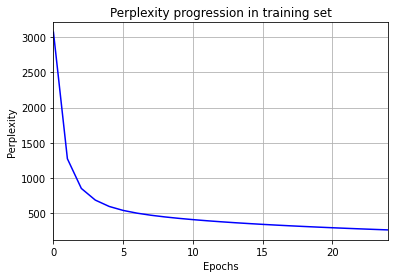

In [31]:
# plot training loss
plt.plot(ppl_train_his, label='training loss', color='blue')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
# title
plt.title('Perplexity progression in training set')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
#plt.legend() # add legend
plt.show()

### 5.2 Perplexity during validation

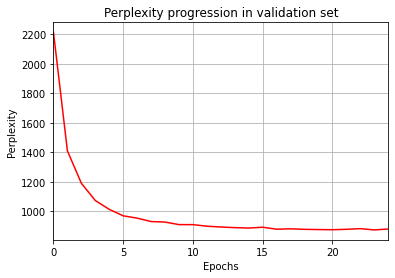

In [32]:
# plot validation loss
plt.plot(ppl_val_his, label='validation loss', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
# title
plt.title('Perplexity progression in validation set')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
#plt.legend() # add legend
plt.show()

### 5.3 Both curves in a single plot

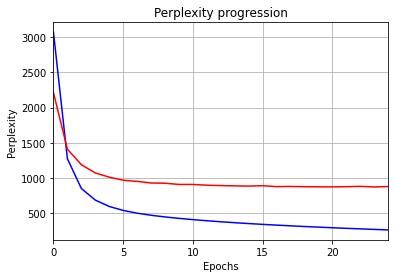

In [33]:
# plot training loss
plt.plot(ppl_train_his, label='training loss', color='blue')
plt.plot(ppl_val_his, label='validation loss', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
# title
plt.title('Perplexity progression')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
#plt.legend() # add legend
plt.show()

### 5.3 Zoom at the minimum of CE loss curve

Epoch with minimum perplexity value = 24


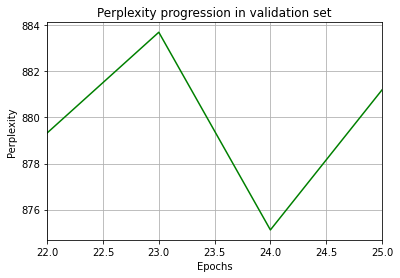

In [34]:
BEST_EPOCH = ppl_val_his.index(min(ppl_val_his)) + 1
print('Epoch with minimum perplexity value =', BEST_EPOCH)
#-------------------------------------------------
# plots
plt.plot(range(max(1,BEST_EPOCH-2),min(EPOCH,BEST_EPOCH+3)), ppl_val_his[max(1,BEST_EPOCH-3):min(EPOCH-1,BEST_EPOCH+2)], 'green')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.autoscale(axis='x', tight=True)
plt.title('Perplexity progression in validation set')
plt.grid(True)
plt.show()

### 5.4 Print the final values of the main training monitoring variables:
- loss function final value:
- metrics final values:

In [35]:
print('last training loss = {0:.4f}'.format(loss_train_his[-1]))
print('last validation loss = {0:.4f}'.format(loss_val_his[-1]))
print('#-------------------------------------------------')
print('last train perplexity = {0:.4f}'.format(ppl_train_his[-1]))
print('last validation perplexity = {0:.4f}'.format(ppl_val_his[-1]))

last training loss = 5.5842
last validation loss = 6.7813
#-------------------------------------------------
last train perplexity = 266.1912
last validation perplexity = 881.1943


## 6. Metrics on test set

### 6.1 Test data loader

In [0]:
BATCH_SIZE_TEST = len(ds_test)
#-------------------------------------------------
# test data loader
dl_test = torch.utils.data.DataLoader(
    dataset = ds_test_emb if PYTORCH_EMBEDDING else ds_test_oh,
    drop_last = False,
    shuffle = True,
    #batch_size = BATCH_SIZE)
    batch_size = BATCH_SIZE_TEST)

In [37]:
tx, ty = iter(dl_test).next()
print('test:', tx.shape, tx.dtype, ty.shape, ty.dtype)

test: torch.Size([100000, 160]) torch.float32 torch.Size([100000]) torch.int64


### 6.2 Cross-Entropy and Perplexity

In [38]:
# load model in CPU
model.to('cpu');
# evaluation mode
model.eval()

NN(
  (hidden): Linear(in_features=160, out_features=100, bias=True)
  (tanh): Tanh()
  (output): Linear(in_features=100, out_features=4125, bias=True)
)

In [39]:
loss_test_batch = torch.zeros(len(dl_test))
# batch test loop
print('testing...')
for b_itest, (b_xtest, b_ytest) in enumerate(dl_test):
    print('batch ', b_itest+1, ' out of ', len(dl_test), sep='', end='; ')
    #b_xtest, b_ytest = b_xtest.to(device), b_ytest.to(device)
    y_logitos = model(b_xtest)
    #-------------------
    '''
    if using the trick to set the '<unk>' logit to -1_000 when the token is
    '<unk>', the cross-entropy loss gets too big (>300), thus making the 
    perplexity to explode to infinite
    so here we put the value -1 to that logit
    ''' 
    # check if target doesn't belongs to vocab
    for idx, token in enumerate(b_ytest):
        if (token == vocab['<unk>']):
            #y_logitos[idx][vocab['<unk>']] = -1000
            y_logitos[idx][vocab['<unk>']] = -1
    #-------------------
    loss_test = loss_func(y_logitos, b_ytest)
    ytest_pred = torch.argmax(y_logitos, dim=1)
    #-------------------
    # metrics
    loss_test_batch[b_itest] = loss_test.item() # test batch loss
loss_test = torch.mean(loss_test_batch)         # test cross-entropy (CE)
ppl_test = torch.exp(loss_test).item()         # test perplexity
loss_test = loss_test.item()

testing...
batch 0 out of 1

In [40]:
print('loss test = {0:.4f}'.format(loss_test), end='\n')
print('ppl test = {0:.4f}'.format(ppl_test), end='\n')

loss test = 6.7930
ppl test = 891.5722


## End of the notebook